## Zillow logerror
#### Lindy Castellaw 8/9/2022

This project will use clustering to find the drivers of error in the Zestimate of single-unit properties that were listed on Zillow in 2017. The goal of the models is to improve the Zestimate residual error.

##### logerror = log(Zestimate) − log(SalePrice)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prepare_zillow import wrangle_zillow
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
pd.options.display.float_format = '{:20,.2f}'.format
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from env import host, user, password
import acquire_zillow
from functions import split, scaled_data 
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, RFE, f_regression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

## Acquire

Acquire data from get_zillow_data that pulls the information we need from SQL.

In [2]:
df = acquire_zillow.get_zillow_data()

## Wrangle

- Handle outliers

- Convert dtypes

- Rename and Bin columns

- Make dummies

In [3]:
df = wrangle_zillow(df)
df.head() # look at top 5 in df

,parcelid,bathroom,bedroom,bed_bath,sqft,finished_sqft,fips,fullbathcnt,garage,hashottuborspa,...,age_bin,acres,acres_bin,dollar_per_sqft,cola,county,has_pool,garage,county_Orange,county_Ventura
0,14297519,3.50,4.00,3.50,"3,100.00","3,100.00",6059,3.00,2.00,0.00,...,10-20,0.10,0.10,156.68,0,Orange,0.00,2.00,1,0
1,17052889,1.00,2.00,1.00,"1,465.00","1,465.00",6111,1.00,1.00,0.00,...,40-50,0.29,0.30,60.07,0,Ventura,0.00,1.00,0,1
2,14186244,2.00,3.00,2.00,"1,243.00","1,243.00",6059,2.00,2.00,0.00,...,50-60,0.19,0.20,68.62,0,Orange,1.00,2.00,1,0
3,12177905,3.00,4.00,3.00,"2,376.00","2,376.00",6037,3.00,0.00,0.00,...,40-50,0.30,0.30,45.84,0,LA,1.00,0.00,0,0
4,12095076,3.00,4.00,3.00,"2,962.00","2,962.00",6037,3.00,0.00,0.00,...,60-70,1.45,0.50,93.41,0,LA,1.00,0.00,0,0


In [4]:
# drop columns
df = df.drop(columns = ['parcelid', 'sqft', 'year_built', 'fips', 'bed_bath', 'propertycountylandusecode', 'county', 'age_bin',
                                       'lot_size', 'regionidzip', 'property_desc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty',
                                       'structuretaxvaluedollarcnt', 'censustractandblock', 'transaction_date', 'roomcnt', 'hashottuborspa', 'assessment_year', 'propertylandusetypeid', 'fullbathcnt']) 


In [5]:
# fill nulls 
df.fillna(value = 0,
          inplace = True)

In [6]:
# split data
train, X_train, X_validate, X_test, y_train, y_validate, y_test = split(df, stratify_by='logerror')

There are large amount of nulls still that we need to fill. Acquired and preped data and filled any remaining nulls then split data into train, validate and test. Once the data is split we cane explore on train.

## Explore

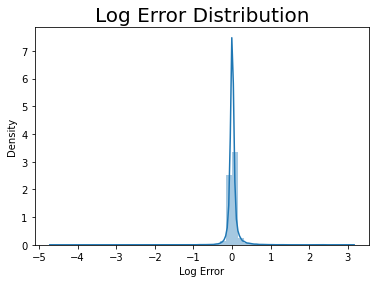

In [7]:
# overall logerror distribution 
sns.distplot(train.logerror)
plt.title('Log Error Distribution', fontsize=20)
plt.xlabel('Log Error')

plt.show()

In [ ]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='age', y='logerror', data=train, alpha=.4)
plt.xlabel('Home age')
plt.ylabel('Log Error')
plt.title('Does age of a home impact log error?')
plt.show()

In [ ]:
plt.scatter(train.logerror,train.home_value)
plt.xlabel('Logerror')
plt.ylabel('Home Value')
plt.title('Logerror vs Home Value')

Logerror has a normal distribution but not necessarily linearly correlated with home_value, also we can see that there is one for finished sqft


## Testing

We used pearsonr test on home_value and home age with an alpha of 0.05. We were able to reject the null for age with a P value of .01, they do have a relationship. We failed to reject the null for home value and though they do not have a linear relationship they do seem to have some sort of relationship, so we will use both for modeling.

#### 𝐻o : Overall home value has no effect on logerror
#### 𝐻𝑎 : Over home value does have an effect on logerror

In [ ]:
x = train.home_value
y = train.logerror
alpha = 0.05
alternative_hypothesis = 'house value is related to logerror'

corr, p = stats.pearsonr(x, y)

corr, p

if p < alpha:
    print("We reject the null hypothesis that there is no effect")
else:
    print("We fail to reject the null")
    
p

#### 𝐻o : There is no difference in median log error in properties built in different years
#### 𝐻𝑎 : Property age affects median log error

In [ ]:

x = train.age
y = train.logerror

r, p = stats.pearsonr(x,y)


if p < alpha:
    print("We reject the null hypothesis that there is no difference in log error based on a home's age.")
else:
    print("We fail to reject the null hypothesis")
    
p

## Clustering 

We will be clustering three different groups:

- Physical features: Latitude, Longitude, Acres, Sqft, Cola

- Age, Acres_bin, dollar_per_sqft

- Tax: home_value, land_tax, taxrate

First scale the date using MinMax then constructed several clusters of these features. The elbow meathod was used to find what would be best for K. SelectKBest was fitted to the different features.

In [8]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(X_train)

# Use the scaler
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

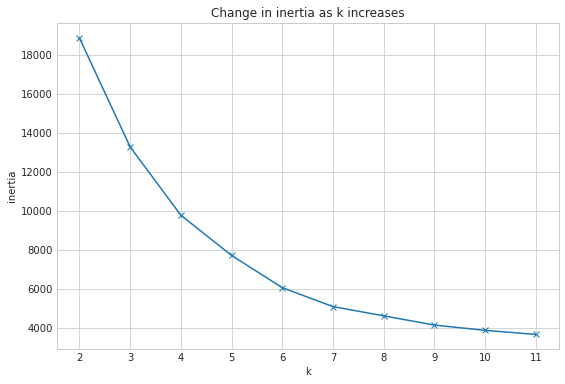

In [9]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

By using the Elbow meathod I will be using 3 as K.

Cluster 1

The higher the land tax the lower the logerror and there is drasticly more the lower the tax.

In [10]:
X1 = X_train_scaled[['home_value', 'land_tax', 'taxrate']]
X2 = X_validate_scaled[['home_value', 'land_tax', 'taxrate']]
X3 = X_test_scaled[['home_value', 'land_tax', 'taxrate']]
# Make the kmeans object
kmeans = KMeans(n_clusters=3)
# fit the kmeans model
kmeans.fit(X1)
kmeans.predict(X1)

array([0, 0, 1, ..., 2, 0, 0], dtype=int32)

In [11]:
X_train_scaled['cluster_tax'] = kmeans.predict(X1)
X_validate_scaled['cluster_tax'] = kmeans.predict(X2)
X_test_scaled['cluster_tax'] = kmeans.predict(X3)

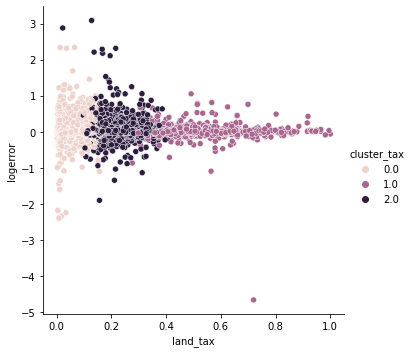

In [15]:
sns.relplot(data=X_train_scaled, x='land_tax', y=y_train.logerror, hue='cluster_tax')

Cluster 2

This cluster is harder see, it is pretty muddled and I cant make out many groupings.

In [12]:
X1 = X_train_scaled[['latitude', 'longitude', 'cola', 'acres_bin', 'finished_sqft']]
X2 = X_validate_scaled[['latitude', 'longitude', 'cola', 'acres_bin', 'finished_sqft']]
X3 = X_test_scaled[['latitude', 'longitude', 'cola', 'acres_bin', 'finished_sqft']]
# Make the kmeans object
kmeans = KMeans(n_clusters=6)
# fit the kmeans model
kmeans.fit(X1)
kmeans.predict(X1)

array([4, 2, 3, ..., 1, 2, 1], dtype=int32)

In [13]:
X_train_scaled['cluster_sca'] = kmeans.predict(X1)
X_validate_scaled['cluster_sca'] = kmeans.predict(X2) # fit on validate and test
X_test_scaled['cluster_sca'] = kmeans.predict(X3)

In [ ]:
sns.relplot(data=X_train_scaled, x='finished_sqft', y=y_train.logerror, hue='cluster_sca')

Cluster 3

This cluster is slightly muddled but I can see groupings. There are some outliers but generally the older the house the less logerror.

In [14]:
X1 = X_train_scaled[['age', 'acres_bin', 'dollar_per_sqft']]
X2 = X_validate_scaled[['age', 'acres_bin', 'dollar_per_sqft']]
X3 = X_test_scaled[['age', 'acres_bin', 'dollar_per_sqft']]
# Make the kmeans object
kmeans = KMeans(n_clusters=3)
# fit the kmeans model
kmeans.fit(X1)
kmeans.predict(X1)

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

In [ ]:
X_train_scaled['cluster_age'] = kmeans.predict(X1)
X_validate_scaled['cluster_age'] = kmeans.predict(X2)
X_test_scaled['cluster_age'] = kmeans.predict(X3)

In [ ]:
sns.relplot(data=X_train_scaled, x='age', y=y_train.logerror, hue='cluster_age')

## Modeling

We used SelectKBest to pick the top three features (Finished_sqft, dollar_per_sqft, county_Orange) to put into our models. Then split the data into X and Y variables, putting logerror into Y. 

The models made:

- Random forest

- Decision tree

- Linear regression

Cluster 2 was dropped as it did not add much value. A predictions df was also made for the models.

In [ ]:
X_train_scaled = X_train_scaled.drop('cluster_sca', axis=1)# drop cluster 2
X_validate_scaled = X_validate_scaled.drop('cluster_sca', axis=1)
X_test_scaled = X_test_scaled.drop('cluster_sca', axis=1)

In [ ]:
kbest = SelectKBest(f_regression, k=3) #select 3 features
kbest.fit(X_train_scaled, y_train)
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=X_train_scaled.columns)

In [ ]:
X_train_scaled.columns[kbest.get_support()]

X_train_transformed = pd.DataFrame(
    kbest.transform(X_train_scaled),
    index=X_train_scaled.index,
    columns=X_train_scaled.columns[kbest.get_support()]
)
X_train_transformed.head()

In [ ]:
# Splitting out X and Y variables for modeling
X_train = X_train_scaled[['finished_sqft','dollar_per_sqft','county_Orange']]
y_train = y_train[['logerror']]

X_validate = X_validate_scaled[['finished_sqft','dollar_per_sqft','county_Orange']]
y_validate = y_validate[['logerror']]

X_test = X_test_scaled[['finished_sqft','dollar_per_sqft','county_Orange']]
y_test = y_test[['logerror']]

In [ ]:
# Creating a dataframe of the actual log errors for comparision throughout modeling process
predictions = y_train[['logerror']]
predictions.head()

In [ ]:
# Creating a baseline model
y_train['mean_logerror'] = y_train.logerror.mean()
rmse_baseline = np.sqrt(mean_squared_error(y_train.logerror, y_train.mean_logerror))

predictions['rsme_baseline'] = ('{:.4f}'.format(rmse_baseline))
print('This is the baseline dataset model performance')
print(f'RSME = {rmse_baseline:.4f}')

In [ ]:
y_train = y_train.drop('mean_logerror', axis=1)

In [ ]:
regressor = RandomForestRegressor(max_depth = 2, random_state=121, n_estimators=100)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)

rf_train = np.sqrt(mean_squared_error(y_train, y_pred))
predictions['rf'] = ('{:.4f}'.format(rf_train))
print('This is the train dataset model performance')
print(f'RSME = {rf_train:.4f}')

In [ ]:
regressor2 = RandomForestRegressor(max_depth = 4, random_state=121, n_estimators=100)
regressor2.fit(X_train, y_train)
y_pred = regressor2.predict(X_train)

rf2_train = np.sqrt(mean_squared_error(y_train, y_pred))
predictions['rf2'] = ('{:.4f}'.format(rf2_train))
print('This is the train dataset model performance')
print(f'RSME = {rf2_train:.4f}')

In [ ]:
regressor3 = DecisionTreeRegressor(max_depth = 5, random_state=121)
regressor3.fit(X_train, y_train)
y_pred = regressor3.predict(X_train)

dt_train = np.sqrt(mean_squared_error(y_train, y_pred))
predictions['dt'] = ('{:.4f}'.format(dt_train))
print('This is the train dataset model performance')
print(f'RSME = {dt_train:.4f}')

In [ ]:
lm = LinearRegression()
# Fitting the data to model
lm.fit(X_train, y_train)

y_pred = lm.predict(X_train)
lm_train = np.sqrt(mean_squared_error(y_train, y_pred))
predictions['lm'] = ('{:.4f}'.format(lm_train))
print('This is the train dataset model performance')
print(f'RSME = {lm_train:.4f}')

Testing on Validate

In [ ]:
y_pred = lm.predict(X_validate) # fit to validate
lm_validate = np.sqrt(mean_squared_error(y_validate, y_pred))
predictions['lm_validate'] = ('{:.4f}'.format(lm_validate)) # put prediction into df

y_pred = regressor.predict(X_validate)
rf_validate = np.sqrt(mean_squared_error(y_validate, y_pred))
predictions['rf_validate'] = ('{:.4f}'.format(rf_validate))

y_pred = regressor2.predict(X_validate)
rf2_validate = np.sqrt(mean_squared_error(y_validate, y_pred))
predictions['rf2_validate'] = ('{:.4f}'.format(rf2_validate))

y_pred = regressor3.predict(X_validate)
dt_validate = np.sqrt(mean_squared_error(y_validate, y_pred))
predictions['dt_validate'] = ('{:.4f}'.format(dt_validate))

In [ ]:
predictions.head()

All of the models performed similarly and did not quite beat the baseline on train data. All of the models did beat the baseline on the validate set, with Decision Tree at a max depth of 5 preformed the highest but did not preform well on train.


In [ ]:
# Model on test
y_pred = regressor3.predict(X_test)
dt_test = np.sqrt(mean_squared_error(y_test, y_pred))
# put into df
predictions['dt_test'] = ('{:.4f}'.format(dt_test))
predictions.head()

## Conclusion

The three best features were finished_sqft, dollar_per_sqft, county_Orange.

The main featured used seemed to focue on location, cost and size. 

Tax and home value have higher than average log error. 

Clusters were not significant, did not improve modeling.

We observed some statistical difference between log error with regards to these features:

- Longitude/Latitude
- Lot size
- Square footage
- Age of the home


### Next steps:

More information about the area of the homes would be valuble like ISD. Since value affects logerror getting information on homeowners, maybe income, could be used as a variable for clustering.